# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

**2022 update:** Rendering was disabled, and the notebook now uses the `colabgymrender` package to render a video.

**2023 update:** Changed to packages `gymnasium` and `renderlab`, and to `CartPole-v1`.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gymnasium.farama.org/environments/classic_control/cart_pole/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*.

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [1]:
!pip install gymnasium
!pip install renderlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 15.7 MB/s eta 0:00:00


 **If run on your local machine**, you may need to install `gymnasium[classic-control]` by running the following line:

In [2]:
!pip install "gymnasium[classic-control]"

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import renderlab as rl

  if event.key is 'enter':



First we create the environment:

In [4]:
env = gym.make('CartPole-v1') # Create environment

A state in this environment is four numbers describing the position and speed of the cart along with the angle and angular speed of the pole.

There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [5]:
s, _ = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [-0.04956045  0.02972598 -0.00410276  0.02164727]
sample action: 1


Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [6]:
env = gym.make("CartPole-v1", render_mode = "rgb_array") # Create environment
env = rl.RenderFrame(env, "./output") # To display environment in the notebook
env.reset() # Reset environment

# Run environment
while True:
    action = env.action_space.sample() # Get a random action
    _, _, done, _, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  71%|███████▏  | 15/21 [00:00<00:00, 146.84it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1735762220.3237484.mp4, 720000 bytes wanted but 0 bytes read,at frame 20/21, at time 0.67/0.67 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [7]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)

    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [8]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [9]:
n_inputs = env.observation_space.shape[0]
n_hidden = 32
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [10]:
# best training settings
n_hidden = 32
num_episodes = 600
rollout_limit = 500 # max rollout length
discount_factor = 0.95 # reward discount factor (gamma)
learning_rate = 5e-4 # optimal
val_freq = 100 # validation frequency

In [19]:
# training settings

num_episodes = 800
rollout_limit = 500 # max rollout length
discount_factor = 0.95 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 5e-4 # you know this by now
val_freq = 100 # validation frequency
baseline_rolls = 5

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s, _ = env.reset()

        # generate rollout (episode) by iteratively evaluating the current policy on the environment
        for j in range(rollout_limit):
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break

        # prepare batch data
        states, actions, rewards, = zip(*rollout)
        states = np.vstack(states)
        actions = np.vstack(actions)
        rewards = np.array(rewards, dtype=float)

        # compute discounted returns from current episode
        returns = compute_returns(rewards, discount_factor)

        # simple baseline (reduced variance) -> substract mean of returns
        baseline = np.mean(returns)
        advantages = returns - baseline

        # policy gradient update
        policy.optimizer.zero_grad()

        # probability of chosen actions under the current policy
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)

        # compute loss wrt advantages instead of raw returns
        loss = policy.loss(a_probs, torch.from_numpy(advantages).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # evaluation printout
        if (i+1) % val_freq == 0:
            # validation rewards
            validation_rewards = []
            for _ in range(10):
                s, _ = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
 100. mean training reward:  23.44, mean validation reward:   8.80, mean loss:  0.0222
 200. mean training reward:  22.89, mean validation reward:  24.20, mean loss: -0.0284
 300. mean training reward:  29.97, mean validation reward:  38.70, mean loss: -0.0309
 400. mean training reward:  31.10, mean validation reward:  58.40, mean loss: -0.0483
 500. mean training reward:  42.93, mean validation reward:  82.80, mean loss: -0.0263
 600. mean training reward:  64.00, mean validation reward: 333.30, mean loss: -0.0747
 700. mean training reward: 128.38, mean validation reward: 262.00, mean loss: -0.0984
 800. mean training reward: 220.28, mean validation reward: 486.40, mean loss: -0.0864
done


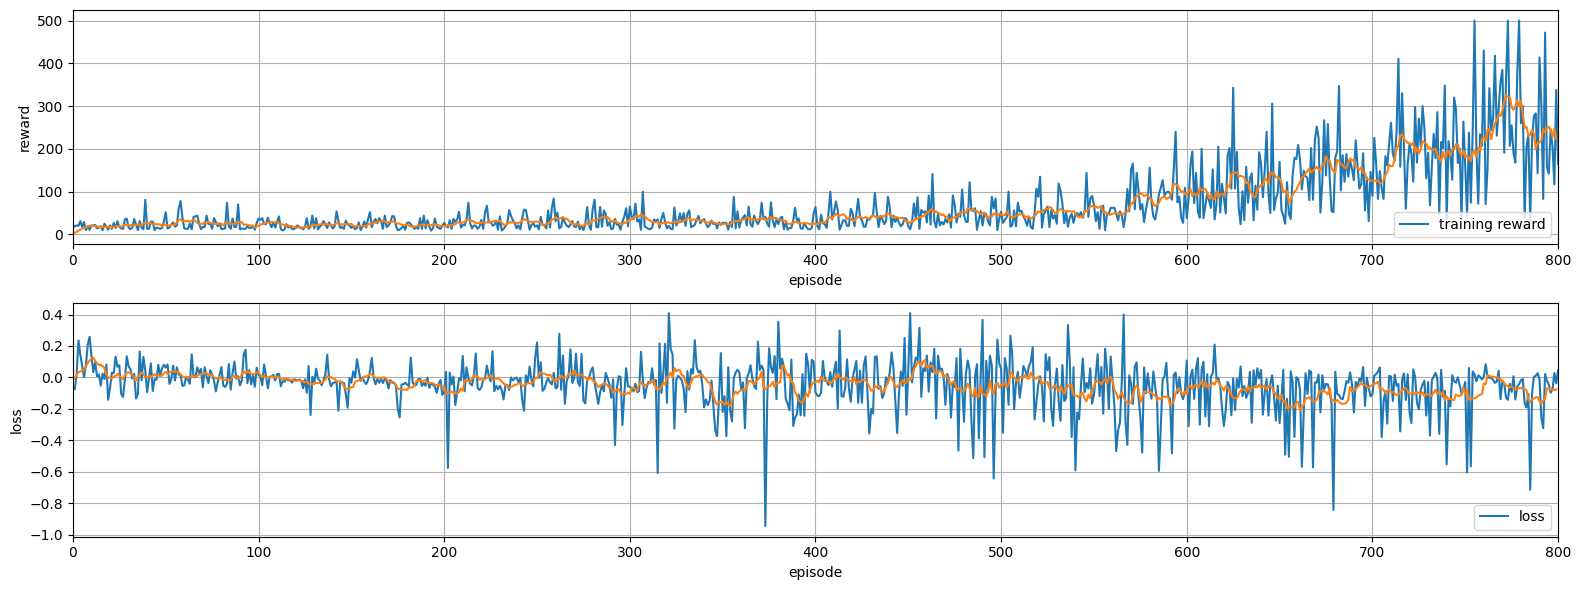

In [20]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

In [21]:
env = rl.RenderFrame(env, "./gym-results") # Create wrapper to display environment
s,_ = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _, _ = env.step(a)
    if done: break

env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


## Reducing variance via Baselining

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**
* `Episode Number`: Training episodes offer the agent more chances to explore, collect data and update its policy, until it converges. Given a well-tuned pair of learning rate and discount factor, the episodes increase the chance of convergence (simpler problems).

* `Discount Factor`: establishes the time horizon of the REINFORCE learning process. Longer time horizons have have much **more variance** as they include more irrelevant information, while short time horizons are **biased** towards only short-term gains. The discount factor essentially determines how much the reinforcement learning agents cares about rewards in the distant future relative to those in the immediate future, leading to faster learning. Ideal setting: $0.9 - 0.95$

* `Learning Rate`: decreased LR reduces the amount of oscilattion (over-shooting) around the minima in the stochastic gradient descend mechanism and controls how impactful are local weight optimization based on the acquired insight. Additionally, helps for a smoother learning curve that can achieve higher performance if building up appropriately, caveat: **slower convergence**.

* `Hidden Layers and Neurons`: increase triggers an increase in the number of learnable parameters to capture more complex relationships between actions and states, hence overall better final performance.

### Exercise 2

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

$[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]$


* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**
* `Total Reward`: $5$
* `Total Future Reward per Timestep`: $[5, 5, 4, 3, 2, 2, 1, 0, 0, 0]$
* `Discounted Future Reward per Timestep`:

$[ 0.9 + 0.81 + 0.729 + 0.5905 + 0.53144 = 3.56093, \\ 1 + 0.9 + 0.81 + 0.6561 + 0.5905 = 3.9566, \\ 1 + 0.9 + 0.729 + 0.6561 = 3.2851, \\ 1 + 0.81 + 0.729 = 2.539, \\ 0.9 + 0.81 = 1.71, \\ 1 + 0.9 = 2.9, \\ 1, 0, 0, 0]$

### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**
- Throughout `training` the agent samples actions **stochastically** based on the computed action probabilities in the policy. This exploratory behaviour can lead to suboptimal actions (lower rewards) on average, but is necessary to gather diverse experience and improve the policy.

- Throughout `validation` however the agent chooses the action with the **highest probability** `argmax` rather than stochastic sampling. This greedy selection removes the exploration noise, typically leading to higher rewards because the agent picks the best action according to the policy in each state.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**
- Policy gradient methods naturally incorporate `exploration` by maintaining a **stochastic policy**. In other words, at each step during training, the agent samples an action from its policy distribution  $\pi_\theta(a \mid s)$  rather than choosing the single best (greedy) action. This randomness ensures the agent tries out different actions and states—i.e., it `explores`—instead of always exploiting the single highest-probability action.

- Over time, as the policy parameters update, the distribution shifts to put more probability on actions that yield higher returns, benefiting from the learned patterns - `exploitation`. But until it fully converges, there is always some chance (depending on the policy’s entropy) that the agent will select suboptimal actions, which drives `exploration`.

*An inherent property of the `sampling approach (softmax action selection)` is that it will gradually reduce exploration and start exploiting as it learns and becomes more confident in the most rewarding actions.*

## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate.

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*

*	By computing the mean return at each timestep across V rollouts, you get a more stable baseline (as opposed to the per-episode mean) because it’s averaged over multiple samples.
*	This reduces the variance of the gradient estimate. In turn, training can become more stable and converge faster.

In [16]:
# training settings

num_episodes = 500
rollout_limit = 400 # max rollout length
discount_factor = 0.95 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 5e-4 # you know this by now
val_freq = 100 # validation frequency
baseline_rolls = 5 # baseline rollouts V - batch size

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollouts = []

        # generate batch of rollouts by repeatedly evaluating the current policy on the environment
        # batch of V full trajectories for each update loop
        for v in range(baseline_rolls):
          rollout = []
          s, _ = env.reset()
          # generate a single rollout (T steps) evaluating the current policy
          for j in range(rollout_limit):
              with torch.no_grad():
                  a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                  a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
              s1, r, done, _, _ = env.step(a)
              rollout.append((s, a, r))
              s = s1
              if done: break
          rollouts.append(rollout)

        # compute discounted returns in current episode for each rollout - prepare batch data
        # stored in a list of arrays, returns[v][t] = discounted return at time t for rollout v
        returns_list = []
        for v in range(baseline_rolls):
          states_v, actions_v, rewards_v, = zip(*rollouts[v])
          rewards_v = np.array(rewards_v, dtype=float)

          # compute discounted returns from current episode ad rollout
          returns_v = compute_returns(rewards_v, discount_factor) # length of rollout
          returns_list.append(returns_v)

        # simple baseline (reduced variance) -> substract mean of returns `baseline = np.mean(returns)`

        # compute baseline for each time step t across the V rollouts
        max_T = max(len(r) for r in rollouts) # max length across all rollouts

        # accumulate returns over rollouts for each episode t, then divide by V (baseline rollouts)
        baseline = np.zeros(max_T)
        counts   = np.zeros(max_T)

        for v in range(baseline_rolls):
            R_v = returns_list[v]
            for t in range(len(R_v)):
                baseline[t] += R_v[t]
                counts[t] += 1

        # avoid dividing by zero, though we expect counts[t] > 0 for the first T_v steps
        for t in range(max_T):
            if counts[t] > 0:
                baseline[t] /= counts[t]


        # compute advantages for all timesteps in all rollouts - flatten for single gradient update
        all_states = []
        all_actions = []
        all_advantages = []

        for v in range(baseline_rolls):
          states_v, actions_v, rewards_v = zip(*rollouts[v])
          returns_v = returns_list[v]

          # for each time step t in this rollout, advantage[t] = R_v[t] - baseline[t]
          advantages_v = []
          for t in range(len(returns_v)):
              adv = returns_v[t] - baseline[t]
              advantages_v.append(adv)

          # Convert states and actions to arrays/tensors
          states_v = np.vstack(states_v)
          actions_v = np.vstack(actions_v)

          all_states.append(states_v)
          all_actions.append(actions_v)
          all_advantages.append(np.array(advantages_v))

        # flatten everything across V (baseline_rolls) rollouts `advantages = returns - baselines`
        all_states_np   = np.concatenate(all_states, axis=0)  # shape: [sum_of_lengths, state_dim]
        all_actions_np  = np.concatenate(all_actions, axis=0) # shape: [sum_of_lengths, 1]
        all_advantages_np = np.concatenate(all_advantages, axis=0)  # shape: [sum_of_lengths]

        # policy gradient update
        policy.optimizer.zero_grad()

        # probability of chosen actions under the current policy
        a_probs = policy(torch.from_numpy(all_states_np).float()).gather(1, torch.from_numpy(all_actions_np)).view(-1)

        # compute loss wrt advantages instead of raw returns
        loss = policy.loss(a_probs, torch.from_numpy(all_advantages_np).float())
        loss.backward()
        policy.optimizer.step()

        # bookkeeping
        # training_rewards.append(sum(rewards))
        avg_reward = np.mean([sum(r[2] for r in roll) for roll in rollouts])
        training_rewards.append(avg_reward)
        losses.append(loss.item())
        # evaluation printout
        if (i+1) % val_freq == 0:
            # validation rewards
            validation_rewards = []
            for _ in range(10):
                s, _ = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
 100. mean training reward:  25.47, mean validation reward:  44.20, mean loss: -0.0274
 200. mean training reward:  35.94, mean validation reward: 104.00, mean loss: -0.0702
 300. mean training reward:  60.19, mean validation reward: 149.20, mean loss: -0.0650
 400. mean training reward: 144.04, mean validation reward: 396.00, mean loss: -0.0584
 500. mean training reward: 217.39, mean validation reward: 456.40, mean loss: -0.0338
interrupt


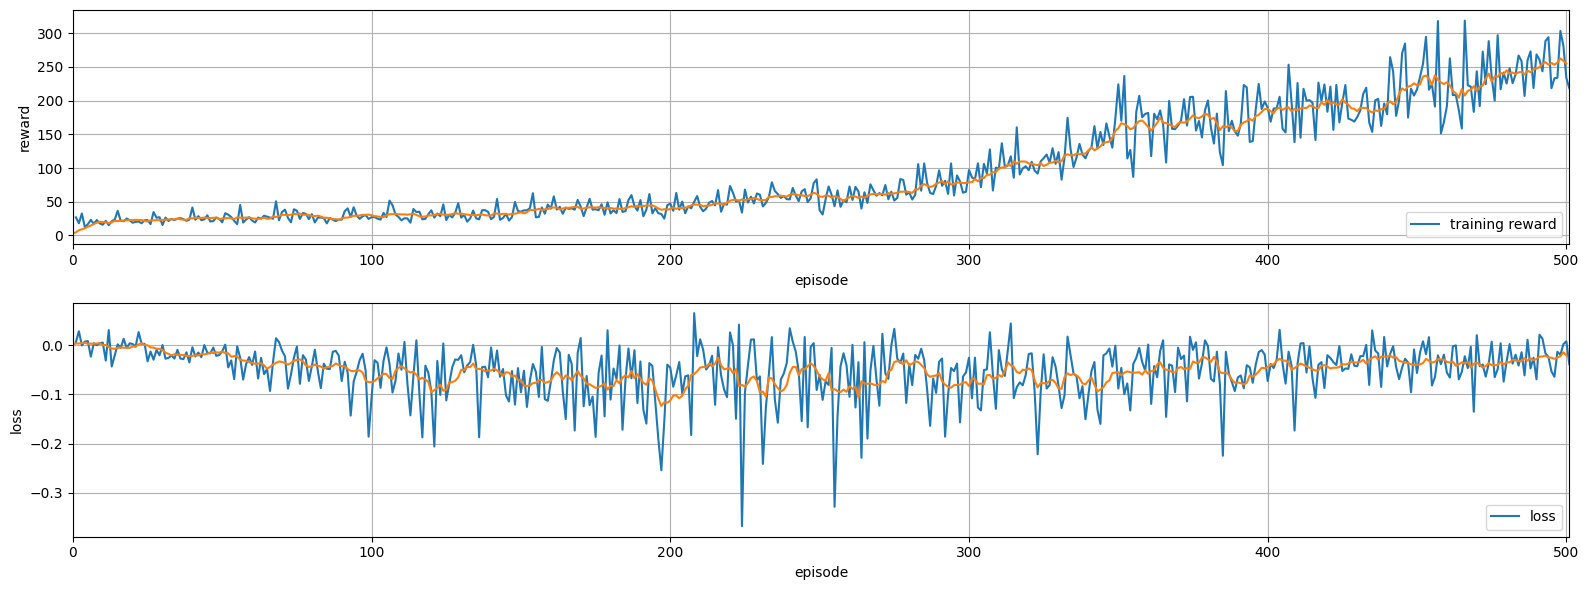

In [17]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [18]:
env = rl.RenderFrame(env, "./gym-results") # Create wrapper to display environment
s,_ = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _, _ = env.step(a)
    if done: break

env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4
